<p align="center">
Universidade Federal de Alagoas</br>

Instituto de Computação</br>

</p>

#Trabalho Prático AB2

Disciplina: Sistemas Distribuídos

Semestre letivo: 2017.1

Professor: André Lage Freitas

## Especificação

**Importante**. Leia atentamente essa seção pois só serão aceitos trabalhos que obedecerem as a especificações a seguir. 

Baseado(a) no exemplo a seguir de implementação do B-multicast em Julia, façam os exercícios descritos nesse documento.

In [1]:
using Distributed
using Plots
using StatsPlots

function mean(array)
    return(sum(array) / length(array))
end

function std(array)
    s, m = 0, mean(array)
    for x in array
        s += (x - m)*(x - m)
    end
    return(sqrt(s / (length(array) - 1)))
end

std (generic function with 1 method)

In [2]:
z, iterations = 1.96, 50
addprocs(10)
group = workers()

10-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [3]:
@everywhere function B_deliver(message)
#     println(message)
#     flush(stdout)
    sleep(0.01)
end

function B_sync_multicast(group, message, B_deliver)
    for i in group
        @sync @spawnat i B_deliver(message)
    end
end

function B_async_multicast(group, message, B_deliver)
    @sync for i in group
        @spawnat i B_deliver(message)
    end
end

B_async_multicast (generic function with 1 method)

In [4]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed B_sync_multicast(group, "Sync hi  -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

In [5]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed B_async_multicast(group, "Async hi -- $i", B_deliver))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

Sync total time: 11.636923802 || Async total time: 0.5811019
Sync mean time: 0.29092309505 || Async mean time: 0.014527547499999998
Sync std time: 1.0794703475811955 || Async std time: 0.0025475905595506794
Sync: [0.110596, 0.110611, 0.110611, 0.110634, 0.111536, 0.111587, 0.112423, 0.112526, 0.112537, 0.112748, 0.113441, 0.113454, 0.113547, 0.113573, 0.114332, 0.114649, 0.114693, 0.11754, 0.117594, 0.117679, 0.11773, 0.118345, 0.119546, 0.120278, 0.121335, 0.121343, 0.121487, 0.121534, 0.121538, 0.121607, 0.121778, 0.12179, 0.122559, 0.122656, 0.124729, 0.126333, 0.144376, 0.160101, 0.174591, 6.94695]
Async: [0.0135329, 0.013543, 0.0135582, 0.0135686, 0.0135933, 0.0136076, 0.01361, 0.0136174, 0.0136227, 0.0136899, 0.0137265, 0.0137366, 0.0137473, 0.0138122, 0.0138147, 0.0138698, 0.0139025, 0.0139095, 0.0139237, 0.0139652, 0.0139667, 0.0139738, 0.0139928, 0.0140677, 0.0141076, 0.014114, 0.0141685, 0.0141949, 0.0143005, 0.0145196, 0.0145566, 0.0146053, 0.0146602, 0.0147673, 0.0149025, 0

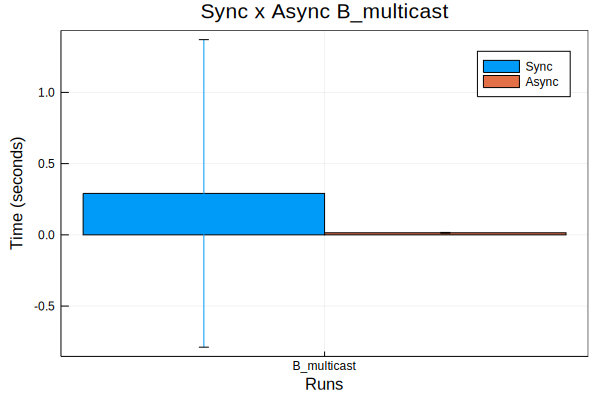

In [6]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(1, 10))
deleteat!(asyncTimes, UnitRange(1, 10))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["B_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async B_multicast",
           framestyle = :box)

# -------------------------------------------------------------------------------------
# R_multicast começa aqui
# -------------------------------------------------------------------------------------

In [20]:
z, iterations = 1.96, 50
rmprocs(workers())
addprocs(10)
group = workers()

10-element Array{Int64,1}:
 32
 33
 34
 35
 36
 37
 38
 39
 40
 41

In [21]:
counter = 0

@everywhere function B_sync_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if from != myid()
            B_sync_multicast(group, message, B_sync_deliver)
        end
        sleep(0.01)
    end
    @spawnat 1 global counter += 1
end

@everywhere function B_sync_multicast(group, message, B_deliver)
    my_id = myid()
    for i in group
        @sync @spawnat i B_sync_deliver(group, my_id, message)
    end
end

function R_sync_multicast(group, message)
    @everywhere group global received = Set()

    for i in group
        @sync @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end
    
@everywhere function B_async_deliver(group, from, message)
    global received
#     println(message)
#     flush(stdout)
#     sleep(0.01)
    
    if !(from in received)
        push!(received, from)
        if (from != myid())
            B_async_multicast(group, message, B_async_deliver)
        end
        sleep(0.01)
    end
end

@everywhere function B_async_multicast(group, message, B_deliver)
    my_id = myid()
    @sync for i in group
        @spawnat i B_async_deliver(my_id, message)
    end
end

function R_async_multicast(group, message)
    @everywhere group global received = Set()

    @sync for i in group
        @spawnat i B_sync_multicast(group, message, B_sync_deliver)
    end
end

R_async_multicast (generic function with 1 method)

In [22]:
syncTimes = []
for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(syncTimes, @elapsed R_sync_multicast(group, "Sync hi  -- $i"))
    if i == 1
        println(counter)
    end
end

1 -----------------------------------
1000
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 --------------------------

In [10]:
asyncTimes = []
asyncTotalTime = for i in 1:iterations
    println("$i -----------------------------------")
    flush(stdout)
    push!(asyncTimes, @elapsed R_async_multicast(group, "Async hi -- $i"))
end

1 -----------------------------------
2 -----------------------------------
3 -----------------------------------
4 -----------------------------------
5 -----------------------------------
6 -----------------------------------
7 -----------------------------------
8 -----------------------------------
9 -----------------------------------
10 -----------------------------------
11 -----------------------------------
12 -----------------------------------
13 -----------------------------------
14 -----------------------------------
15 -----------------------------------
16 -----------------------------------
17 -----------------------------------
18 -----------------------------------
19 -----------------------------------
20 -----------------------------------
21 -----------------------------------
22 -----------------------------------
23 -----------------------------------
24 -----------------------------------
25 -----------------------------------
26 -------------------------------

Sync total time: 70.56444430399999 || Async total time: 9.480701698
Sync mean time: 1.7641111075999998 || Async mean time: 0.23701754245
Sync std time: 2.312714351896966 || Async std time: 0.016120949320220294
Sync: [1.35941, 1.36, 1.3602, 1.36388, 1.36501, 1.36623, 1.36843, 1.36919, 1.37622, 1.37708, 1.3772, 1.37817, 1.38203, 1.38287, 1.38298, 1.38474, 1.388, 1.38982, 1.39139, 1.39236, 1.39356, 1.39363, 1.3947, 1.39792, 1.39825, 1.39848, 1.39939, 1.4009, 1.40712, 1.40858, 1.41045, 1.4118, 1.41457, 1.42405, 1.44309, 1.45359, 1.46646, 1.50031, 1.50866, 16.0237]
Async: [0.217758, 0.218465, 0.22159, 0.223795, 0.224313, 0.225329, 0.226372, 0.227015, 0.227222, 0.227441, 0.22791, 0.228405, 0.228808, 0.229163, 0.230176, 0.230925, 0.232114, 0.233, 0.233857, 0.234128, 0.234817, 0.23542, 0.236622, 0.236746, 0.236953, 0.237083, 0.237656, 0.238559, 0.238816, 0.240458, 0.240826, 0.241567, 0.242717, 0.24398, 0.247632, 0.25112, 0.257218, 0.257861, 0.262961, 0.313901]


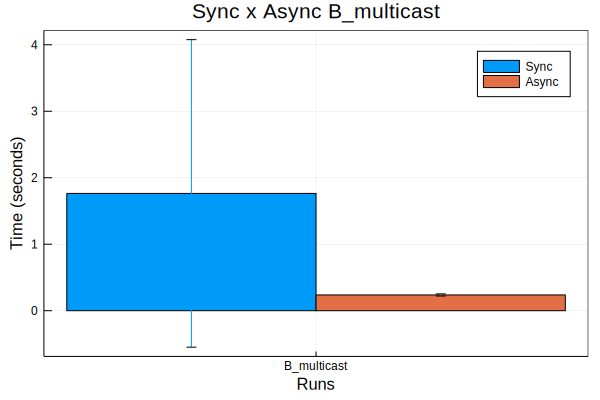

In [11]:
syncTimes, asyncTimes = Array{Float64}(syncTimes), Array{Float64}(asyncTimes)
sort!(syncTimes), sort!(asyncTimes)
deleteat!(syncTimes, UnitRange(length(syncTimes) - 10, length(syncTimes)))
deleteat!(asyncTimes, UnitRange(length(asyncTimes) - 10, length(asyncTimes)))
syncTotalTime, asyncTotalTime = sum(syncTimes), sum(asyncTimes)
syncMeanTime, asyncMeanTime = mean(syncTimes), mean(asyncTimes)
syncStdTime, asyncStdTime = std(syncTimes), std(asyncTimes)

println("Sync total time: $syncTotalTime || Async total time: $asyncTotalTime")
println("Sync mean time: $syncMeanTime || Async mean time: $asyncMeanTime")
println("Sync std time: $syncStdTime || Async std time: $asyncStdTime")
println("Sync: $syncTimes")
println("Async: $asyncTimes")

# plot(1:length(syncTimes),
#          [syncTimes, asyncTimes],
#          title="Sync x Async B_multicast",
#          label=["Sync", "Async"],
#          xlabel="Runs",
#          ylabel="Time (s)")
groupedbar(
           ["R_multicast"],
           [syncMeanTime asyncMeanTime],
           yerr = [syncStdTime asyncStdTime],
           label = ["Sync", "Async"],
           xlabel = "Runs",
           ylabel = "Time (seconds)",
           title = "Sync x Async R_multicast",
           framestyle = :box)

In [12]:
# function B_multicast(g,m,B_deliver)
#    for p in g
#        remotecall(p, B_deliver, m)
#    end
# end

# Adding 3 processes (workers)
#addprocs(3)

# My group is composed by all workers
# g = workers()

# Multicasting "oi!" message to group `g` by assuming `println` as B_deliver function.
# B_multicast(g,"oi!",println)

### Exercício 1: Sincronismo (2,0 pontos)

Adicione 10 processos com o comando `addprocs` abaixo. 

_Atenção_: sua instalação local de Julia pode não conseguir adicionar 10 processos, use a [JuliaBox](https://juliabox.com).

In [13]:
# addprocs(10)

Modifique a implementação do B-multicast para utilizar communicação síncrona.

In [14]:
#TODO implementação do B-multicast síncrono.

Execute as duas versões do B-multicast (síncrona e assíncrona) e compare as saídas.

A ordem das mensagens das saídas foram as mesmas para ambas versões do B-multicast? Por quê?

**Resposta**: _em itálico_



### Exercício 2: Análise de desempenho do B-multicast (2,0 pontos)

Meça o tempo de execução duas versões do B-multicast (síncrona e assíncrona). Dica: utilize a macro `@time`.

* Execute 50 vezes essa medição e construa um gráfico em forma de barras:
	* cada barra representando cada versão do B-multicast;
	* calcule e coloque no gráfico o [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) com nível de 95%.
    
**Gráfico**: _por aqui_    
    
    
* Qual das duas versões teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 3: Análise de desempenho do R-multicast (3,0 pontos)

Implemente duas versões do algoritmo R-multicast: uma assíncrona e outra síncrona.

* R-multicast assíncrono

In [15]:
#TODO implementação do R-multicast síncrono.

* R-multicast assíncrono

In [16]:
#TODO implementação do R-multicast assíncrono.

Faça a mesma análise de desempenho para o R-multicast que você fez no Exercício 2.


**Gráfico**: _por aqui_    
    
    
* Qual das duas versões (R-multicast assíncrono e assíncrono) teve o menor tempo de execução? Por quê?

**Resposta**: _em itálico_



### Exercício 4: Análise de desempenho: B-multicast vs. R-multicast (3,0 pontos)

Para cada uma das comparações abaixo, qual dos algoritmos teve o menor tempo de execução? Por quê?

* B-multicast assíncrono vs. R-multicast assíncrono.
    

**Resposta**: _em itálico_    
    
* B-multicast síncrono vs. R-multicast síncrono.


**Resposta**: _em itálico_

## Entrega

As respostas deverão ser entregues nos devidos campos desse arquivo, ou seja, em [Markdown](https://en.wikipedia.org/wiki/Markdown) e no formato [IJulia Notebook](https://github.com/JuliaLang/IJulia.jl).

O programa deve ser implementado na linguagem de programação **Julia**. Seu trabalho será testado na [JuliaBox](https://juliabox.com), portanto teste seu arquivo IJulia na JulizBox antes de enviá-lo.


### Forma 

O arquivo IJulia Notebook deverá ser entregue ao Professor **exclusivamente através do Google Classroom**.



A responsabilidade sobre a integridade do arquivo contendo trabalho é exclusivamente dos discentes. Serão ignorados os trabalhos cujos arquivos não conseguirem ser abertos pelo Professor.

### Prazos

O prazo de entrega sem atraso é o dia **18/11/17**.

Trabalhos entregues com atraso serão aceitos, no máximo, até o o dia **19/11/17**. Serão descontados 5% da nota obtida por dia de atraso.


## Pontuação extra

O(a) discente que realizar mais tarefas, além do que foi especificado neste trabalho, o professor atribuirá de 0,5 a 1,0 ponto extra a depender da relevância da contribuição no programa. O critério será decidido pelo professor. 

O(a) discente deve indicar qual é a tarefa executada. Por exemplo, adição de funcionalidades, armazenamento de dados em arquivo, documentação de código, comentários em inglês sem erros ortográficos, etc.


**Plágio** A nota zero será atribuída caso haja qualquer tipo de cópia parcial ou integral assim como as devidas medidas legais. Leia a [cartilha sobre plágio](http://www.noticias.uff.br/arquivos/cartilha-sobre-plagio-academico.pdf).

## Disclaimer

Esse material foi elaborado pelo [Prof. André Lage Freitas](https://sites.google.com/a/ic.ufal.br/andrelage/) e está licenciado sob a licença _GNU General Public License v3.0_.